# Alternative Methods

Due to the relationship between the Chebyshev and Fourier bases, there are two major ways to take a derivative in the Chebyshev basis:

1. Via Fourier basis  
   a. Sample the function at Chebyshev points and then pretend you're actually equisampling in a different domain, $\theta$ instead of $x$.  
   b. Transfrom via DCT to get to frequency domain $\omega$.  
   c. Multiply by appropriate $jk$ as when taking Fourier-spectral derivatives.  
   d. Transform back to $\theta$ domain with DCT or DST, depending on evenness or oddness of derivative order.  
   e. Transform back to the $x$ domain via complicated mapping, derived with chain rule.  
   f. Treat the endpoints carefully, because the transform from $\theta$ to $x$ can't be solved explicitly at $\pm 1$.  
2. Via [series coefficient rule](https://scicomp.stackexchange.com/questions/44939/chebyshev-series-derivative-in-terms-of-coefficients)  
   a. Also use Chebyshev points so we can transform from function samples to Chebyshev coefficients in $O(N \log N)$ (although you could technically use any points you like if you're willing to fit the Chebyshev polynomials in $O(N^2)$).  
   d. DCT and do some additional O(N) divisions to get said coefficients.  
   c. Use the derivative rule to get Chebyshev coefficients of the derivative function in Chebyshev series representation.  
   d. Do some additional O(N) multiplications to make DCT coefficients from Chebyshev coefficients and DCT to get function samples in $O(N \log N)$ (or evaluate the function at any points you like in $O(N^2)$).  

In [On the Errors Incurred Calculating Derivatives Using Chebyshev Polynomials](https://www.sciencedirect.com/science/article/pii/0021999192902743) the authors first go through method 2 but find that "Tight coupling between coefficients enables propagation of errors from high frequency to low frequency modes." They then explore method 1, which up until the mapping from $\theta$ back to $x$ has cleaner separation of modes as in the Fourier case. However, [division by powers of $\sqrt{1-x^2}$](https://pavelkomarov.com/spectral-derivatives/math.pdf) then blows up any noise or inexactness in the representation of the function at the edges of the domain ($x \rightarrow \pm 1$). They suggest a third method, which I've found to be no better, covered below.

In [1]:
import sys; sys.path.append('../specderiv') # so I can import specderiv code from a neighboring working directory
from specderiv import cheb_deriv
import numpy as np
import pandas
from scipy.fft import dct, dst
from numpy.polynomial import Chebyshev, Polynomial as poly
from collections import deque
from warnings import warn
from matplotlib import pyplot
from IPython.display import HTML, display
from time import time

### Test Functions

We can take the derivatives of these analytically to compare our numerical methods' answers to reality.

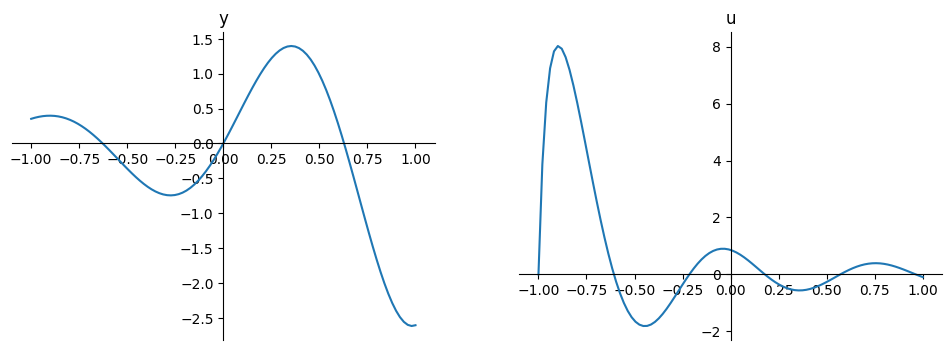

In [2]:
x = np.linspace(-1, 1, 100, endpoint=True)

# Trefethen's classic test function
y = lambda x: np.exp(x) * np.sin(5*x) #+ np.random.randn(*x.shape)*0.05
dy = lambda x: 5*np.exp(x) * np.cos(5*x) + np.exp(x) * np.sin(5*x)
d2y = lambda x: 2*np.exp(x) * (5*np.cos(5*x) - 12*np.sin(5*x))
d3y = lambda x: -2*np.exp(x) * (37*np.sin(5*x) + 55*np.cos(5*x))
d4y = lambda x: 4*np.exp(x) * (119*np.sin(5*x) - 120*np.cos(5*x))

# An additional example function from the Brown paper
u = lambda x: np.sin(8*(x+1))/((x + 1.1)**(3/2))# + np.random.randn(*x.shape)*0.05
du = lambda x: ((8.8 + 8*x)*np.cos(8*(x+1)) - 1.5*np.sin(8*(x+1)))/((x + 1.1)**(5/2))
d2u = lambda x: ((-26.4 - 24*x)*np.cos(8 + 8*x) + (-73.69 + (-140.8 - 64*x)*x)*np.sin(8 + 8*x))/((1.1 + x)**(7/2))
d3u = lambda x: ((-582.472 + x*(-1768.56 + (-1689.6 - 512*x)*x))*np.cos(8 + 8*x) + (335.355 + x*(633.6 + 288.*x))*np.sin(8 + 8*x))/((1.1 + x)**(9/2))
d4u = lambda x: (4096*np.sin(8*(x + 1)))/(x + 1.1)**(3/2) - (1440*np.sin(8*(x + 1)))/(x + 1.1)**(7/2) + (945*np.sin(8*(x + 1)))/(16*(x + 1.1)**(11/2)) + (3072*np.cos(8*(x + 1)))/(x + 1.1)**(5/2) - (420*np.cos(8*(x + 1)))/(x + 1.1)**(9/2)

fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
axes[0].plot(x, y(x))
axes[0].spines['bottom'].set_position('zero')
axes[0].spines['left'].set_position('zero')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_title('y')
axes[1].plot(x, u(x))
axes[1].spines['bottom'].set_position('zero')
axes[1].spines['left'].set_position('zero')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].set_title('u');

## Implementation of Method 1

This was the original method in `spec_deriv.py`, because it's essentially the way suggested by [Trefethen](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8). I've extended this method significantly in [my own analysis](https://pavelkomarov.com/spectral-derivatives/math.pdf) and spilled quite a bit of ink over it, which I've decided to keep for sake of completeness and intuition. Best to also keep the code for reference and comparison to other methods.

In [3]:
def cheb_deriv_via_fourier(y_n: np.ndarray, t_n: np.ndarray, order: int, axis: int=0, filter: callable=None, dct_type=1, calc_endpoints=True):
	"""Evaluate derivatives with Chebyshev polynomials via discrete cosine and sine transforms. Caveats:

	- Taking the 1st derivative twice with a discrete method like this is not exactly the same as taking the second derivative.
	- For derivatives over the 4th, this method presently returns :code:`NaN` at the edges of the domain. Be cautious if passing
	  the result to another function.

	Args:
		y_n (np.ndarray): one-or-multi-dimensional array, values of a function, sampled at cosine-spaced points in the dimension
			of differentiation.
		t_n (np.ndarray): 1D array, where the function :math:`y` is sampled in the dimension of differentation. If you're using
			canonical Chebyshev points with the DCT-I, this will be :code:`x_n = np.cos(np.arange(N+1) * np.pi / N)` (:math:`x
			\\in [1, -1]`). With the DCT-II, :code:`x_n = np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1]))`.
			In either case, on a domain from :math:`a` to :math:`b`, this is stretched to :code:`t_n = x_n * (b - a)/2 + (b + a)/2`.
			Note the order is high-to-low in the :math:`x` or :math:`t` domain, but low-to-high in :math:`n`. Also note both
			endpoints are *inclusive*.
		order (int): The order of differentiation, also called :math:`\\nu`. Must be :math:`\\geq 1`.
		axis (int, optional): For multi-dimensional :code:`y_n`, the dimension along which to take the derivative. Defaults to the
			first dimension (axis=0).
		filter (callable, optional): A function or :code:`lambda` that takes the 1D array of Chebyshev polynomial numbers, :math:`k
			= [0, ... N]`, and returns a same-shaped array of weights, which get multiplied in to the initial frequency transform of
			the data, :math:`Y_k`. Can be helpful when taking derivatives of noisy data. The default is to apply #nofilter.
		dct_type (int, optional): 1 or 2, whether to use DCT-I or DCT-II. Defaults to DCT-I.
		calc_endpoints (bool, optional): Whether to calculate the endpoints of the answer, in case they are unnecessary for a
			particular use case. Defaults to :code:`True`. :code:`False` silences the :code:`NaN` warning for :code:`order` :math:`> 4`.
 
	:returns: (*np.ndarray*) -- :code:`dy_n`, shaped like :code:`y_n`, samples of the :math:`\\nu^{th}` derivative of the function
	"""
	# We only have to care about the number of points in the dimension we're differentiating
	N = y_n.shape[axis] - 1 if dct_type == 1 else y_n.shape[axis] - 3 # if type is 1, we count [0, ... N], if type 2, the endpoints are tacked on additionally
	M = 2*N if dct_type == 1 else 2*(N+1) # Normalization factor is larger for DCT-II based on repeats of endpoints in equivalent FFT
	x_n = np.cos(np.arange(N+1) * np.pi/N) if dct_type == 1 else np.concatenate(([1], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)), [-1])) # canonical sampling

	if order < 1:
		raise ValueError("derivative order, nu, should be >= 1")
	if dct_type not in (1, 2):
		raise ValueError("DCT type must be 1 or 2")
	if len(t_n.shape) > 1 or t_n.shape[0] != y_n.shape[axis]:
		raise ValueError("t_n should be 1D and have the same length as y_n along the axis of differentiation")
	if not np.all(np.diff(t_n) < 0):
		raise ValueError("The domain, t_n, should be ordered high-to-low, [b, ... a]. Try sampling with `np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`")
	scale = (t_n[0] - t_n[-1])/2; offset = (t_n[0] + t_n[-1])/2 # Trying to be helpful, because sampling is tricky to get right
	if not np.allclose(t_n, x_n * scale + offset, atol=1e-5):
		raise ValueError(f"""Your function is not sampled appropriately for the DCT-{'I'*dct_type}. Try sampling with
			{'`np.cos(np.arange(N+1) * np.pi / N) * (b - a)/2 + (b + a)/2`' if dct_type == 1 else
			'`np.concatenate(([b], np.cos((np.arange(N+1) + 0.5) * np.pi/(N+1)) * (b - a)/2 + (b + a)/2, [a]))`'}""")

	first = [slice(None) for dim in y_n.shape]; first[axis] = 0; first = tuple(first) # for accessing different parts of data
	last = [slice(None) for dim in y_n.shape]; last[axis] = -1; last = tuple(last)
	middle = [slice(None) for dim in y_n.shape]; middle[axis] = slice(1, -1); middle = tuple(middle)
	s = [np.newaxis for dim in y_n.shape]; s[axis] = slice(None); s = tuple(s) # for elevating vectors to have same dimension as data

	Y_k = dct(y_n, 1, axis=axis) if dct_type == 1 else dct(y_n[middle], 2, axis=axis) # Transform to frequency domain using the 1st definition of the discrete cosine transform
	k = np.arange(N+1) # [0, ... N], Chebyshev basis polynomial (in x)/wavenumber (in theta) iterator
	if filter: Y_k *= filter(k)[s]

	y_primes = [] # Store all derivatives in theta up to the nu^th, because we need them all for reconstruction.
	for mu in range(1, order + 1):
		Y_mu = (1j * k[s])**mu * Y_k
		if mu % 2: # odd derivative
			# In DST-I case Y_mu[k=0 and N] = 0 and so are not needed for the DST, so only pass the [middle] entries
			# In DST-III case, Y_mu[0 and N+1] = 0. roll() shifts to the left, so Y'_0 is treated like Y'_{N+1}, and we pass in starting at k=1
			y_primes.append(dst(1j * Y_mu[middle], 1, axis=axis).real / M if dct_type == 1 # d/dtheta y = the inverse transform of DST-1 = 1/M * DST-1. Extra j for equivalence with IFFT.
				else dst(1j * np.roll(Y_mu, -1), 3, axis=axis).real / M) # inverse of DST-II is 1/M * DST-III. Im{y_prime} = 0 for real y, so just keep real.
		else: # even derivative
			y_primes.append(dct(Y_mu, 1, axis=axis)[middle].real / M if dct_type == 1 # the inverse transform of DCT-1 is 1/M * DCT-1. Slice off ends to get same length as DST-I result.
				else dct(Y_mu, 3, axis=axis).real / M) # inverse of DCT-II is 1/M * DCT-III. Im{y_prime} = 0 for real y, so just keep real.

	# Calculate the polynomials in x necessary for transforming back to the Chebyshev domain
	numers = deque([poly([-1])]) # just -1 to start, at order 1
	denom = poly([1, 0, -1]) # 1 - x^2
	for nu in range(2, order + 1): # initialization takes care of order 1, so iterate from order 2
		q = 0
		for mu in range(1, nu): # Terms come from the previous derivative, so there are nu - 1 of them here.
			p = numers.popleft() # c = nu - mu/2
			numers.append(denom * p.deriv() + (nu - mu/2 - 1) * poly([0, 2]) * p - q)
			q = p
		numers.append(-q)
	
	# Calculate x derivative as a sum of x polynomials * theta-domain derivatives
	dy_n = np.zeros(y_n.shape) # The middle of dy will get filled with a derivative expression in terms of y_primes
	denom_x = denom(x_n[1:-1]) # only calculate this once; leave off +/-1, because they need to be treated specially anyway
	for term,(numer,y_prime) in enumerate(zip(numers, y_primes), 1): # iterating from lower derivatives to higher
		c = order - term/2 # c starts at nu - 1/2 and then loses 1/2 for each subsequent term
		dy_n[middle] += (numer(x_n[1:-1])/np.power(denom_x, c))[s] * y_prime

	# Calculate the endpoints
	alt = np.ones(N+1); alt[1::2] = -1 # alternating for summing the last point
	if order <= 4 and calc_endpoints:
		C, D = {1: [(-1,), 1], 2: [(1, 1), 3], 3: [(-4, -5, -1), 15], 4: [(36, 49, 14, 1), 105]}[order] # Constants from the math. See the notebook in the warning.
		LH = 0 # L'Hôpital numerator terms
		for i,C_i in enumerate(C, 1): # i starts at 1
			LH += 2 * C_i * (-1)**i * np.power(k, 2*i)
			if dct_type == 1: LH[-1] -= C_i * (-1)**i * np.power(N, 2*i) # because Nth element is outside the 2\sum in the DCT-I
		dy_n[first] = np.sum(LH[s] * Y_k, axis=axis)/ (D*M)
		dy_n[last] = np.sum((LH * alt)[s] * Y_k, axis=axis) / ((-1)**order * D*M)
	else: # For higher derivatives, leave the endpoints uncalculated, but direct the user to my analysis of this problem.
		if calc_endpoints: warn("""endpoints set to NaN, only calculated for 4th derivatives and below. For help with higher derivatives,
			see https://github.com/pavelkomarov/spectral-derivatives/blob/main/notebooks/chebyshev_domain_endpoints.ipynb""")
		dy_n[first] = dy_n[last] = np.nan

	# The above is agnostic to where the data came from, pretends it came from the domain [-1, 1], but the data may actually be
	return dy_n/scale**order # smooshed from some other domain. So scale the derivative by the relative size of the t and x intervals.


## Method 2

Numpy has a class called [Chebyshev](https://numpy.org/doc/2.2/reference/generated/numpy.polynomial.chebyshev.Chebyshev.html), and this class, like other polynomial classes, has a `.deriv()` function. I got curious and started digging and learned that, analogous to [power rule](https://en.wikipedia.org/wiki/Power_rule) for power series, [there is a rule for taking the derivative in terms of a Chebyshev series](https://scicomp.stackexchange.com/questions/44939/chebyshev-series-derivative-in-terms-of-coefficients). Why and how it works is explored in the stackexchange post linked above and in [the math](https://pavelkomarov.com/spectral-derivatives/math.pdf).

I opened [Issue #16](https://github.com/pavelkomarov/spectral-derivatives/issues/16) to explore the implications of this newfound fact. It seemed much of `math.pdf` and [Trefethen himself](https://epubs.siam.org/doi/epdf/10.1137/1.9780898719598.ch8) were overcomplicating differentiation with the Chebyshev basis. This method turns out to be the simplest and shortest to read, write, and understand, comes with other benefits like flexibility in $x$ points (if you're willing to suffer $O(N^3)$ work), and works essentially numerically identically to Method 1, even in the presence of noise (see below), which is maybe surprising.

For all these reasons, I've chosen this method to live in the library code. See [`spec_deriv.py`](https://github.com/pavelkomarov/spectral-derivatives/blob/main/specderiv/specderiv.py) for a complete implementation. Below is a short proof of concept.

In [4]:
N = 20
x_n = np.cos(np.arange(N+1) * np.pi / N)
y_n = y(x_n)
dy_n = dy(x_n)

Y_k = dct(y_n, 1)
weights = np.ones(N+1)*N; weights[0] *= 2; weights[N] *= 2 # for converting between Chebyshev and DCT coefficients
cheb = Chebyshev(Y_k / weights)
dcheb = cheb.deriv() # This class' deriv function calls chebder, works in O(N)
dY_k = np.concatenate((dcheb.coef, [0])) * weights # The derivative loses a coefficient; add back to keep N+1 points
dy_n_dct = dct(dY_k, 1)/(2*N)

print("reconstruction L2 error of y when using chebval:", np.linalg.norm(y_n - cheb(x_n)))
print("reconstruction L2 error of y when using DCT-I:\t", np.linalg.norm(y_n - dct(Y_k, 1)/(2*N)))
print("L2 error of dy when using chebval:\t\t", np.linalg.norm(dy_n - dcheb(x_n)))
print("L2 error of dy when using DCT-I to evaluate:\t", np.linalg.norm(dy_n - dy_n_dct))

reconstruction L2 error of y when using chebval: 1.99450884749725e-15
reconstruction L2 error of y when using DCT-I:	 8.161925587243994e-16
L2 error of dy when using chebval:		 1.3707198853439715e-09
L2 error of dy when using DCT-I to evaluate:	 1.370725804743772e-09


## Method 3

The authors of [On the Errors Incurred Calculating Derivatives Using Chebyshev Polynomials](https://www.sciencedirect.com/science/article/pii/0021999192902743) suggest writing the function to be differentiated, which I'll call $y$ for consistency with myself, as:

$$y(x) = \frac{1+x}{2}y(1) + \frac{1-x}{2}y(-1) + (1-x^2)g(x)$$

Notice that as $x \rightarrow 1$ the rightmost two terms disappear, and we're left with $y(1)$, and similarly for the other end of the domain, so this is a valid representation. We can now take a derivative to find:

$$y'(x) = \frac{y(1) - y(-1)}{2} + \underbrace{(1-x^2)}_{w(x)}g'(x) + \underbrace{-2x}_{w'(x)} g(x)$$

Their claim is that the errors at the edges of the domain accrued in the differentiation process to find $g'$ are now somewhat damped by the weighting term $1-x^2$. However, notice that if all we have to start with is $y$, and $y$ is *numerical* rather than analytic, containing some kind of noise, then when we find $g$ by algebraically manipulating the first equation, we'll end up having to divide by $1-x^2$, which will blow up noise from the edges of $y$. Not great.

If we substitute $g$ in terms of $y$ back in to $y'$ we get:

$$y'(x) = \frac{y(1) - y(-1)}{2} + w(x)g'(x) + \frac{w'(x)}{w(x)} \Big( \frac{y(x) - \frac{1+x}{2}y(1) - \frac{1-x}{2}y(-1)}{1-x^2} \Big)$$

So really in order to shrink any blowup in both $g'$ and $g$, we need both $w$ and $\frac{w'}{w}$ to go to zero at the domain edges. This turns out to be impossible. Proof:

$$ \frac{w'(x)}{w(x)} = \frac{d}{dx} \ln(w(x)) =: h'(x) $$
$$ w(x) \rightarrow 0 \iff h(x) = \ln(w(x)) \rightarrow -\infty$$

So we need $h$ to go to $-\infty$ while $h'$ goes to 0, i.e. approach negative infinity with zero slope. This is possible on an infinite interval, but we are on the finite interval $[-1, 1]$, so no such $h$ can exist and therefore no such $w$. $\blacksquare$

This fundamental limitation is unfortunate but not completely unexpected, since uniform sample uncertainty $\Delta y$ over closer and closer samples $\Delta x \rightarrow \epsilon $ will fundamentally cause a blowup in $\frac{\Delta y}{\Delta x}$.

There is also an additional wrinkle caused by $w$ going to 0 at the domain edges, which makes it impossible to evaluate $g$ directly there. The authors reassure us that if $w$ is polynomial we can use orthogonality of Chebyshev polynomials to set up a system of equations to solve for the endpoints, but this is annoying.

However, since they *do not* touch on intentionally *filtering* noise by culling high-frequency modes, I wondered whether this method could indeed improve upon the others and coded it up.

In [5]:
def brown_deriv(y_n: np.ndarray, x_n, order, filter: callable=None, filter_input=True, filter_g=False):
	"""Brown paper method. We write y(x) = (1+x)y(1)/2 + (1-x)y(-1)/2 + (1-x^2)g(x), where we don't know g but can find g.
	Now we can take the derivative y'(x) = (y(1) - y(-1))/2 + (1-x^2)g'(x) - 2xg(x). We can get g' from g via the Chebyshev
	coefficients recursion. Both g and g' blow up at the edges, but the effect is balanced in the case of g' by multiplication
	with 1-x^2.
	
	Args:
		y_n (np.ndarray): one-or-multi-dimensional array, values of a function, sampled at cosine-spaced points in the dimension
			of differentiation.
		x_n (np.ndarray): assumed to be canonical cosine-spaced points
		order (int): The order of differentiation, also called :math:`\\nu`. Must be :math:`\\geq 1`.
		filter (callable, optional): A function or :code:`lambda` that takes the 1D array of Chebyshev polynomial numbers, :math:`k
			= [0, ... N]`, and returns a same-shaped array of weights, which get multiplied in to the initial frequency transform of
			the data, :math:`Y_k`. Can be helpful when taking derivatives of noisy data. The default is to apply #nofilter.
		filter_input (bool, optional): Whether to apply the filter to :math:`y` at input-time.
		filter_g (bool, optional): Whether to apply the filter to :math:`g`, deeper in the process.

	:returns: (*np.ndarray*) -- :code:`dy_n`, shaped like :code:`y_n`, samples of the :math:`\\nu^{th}` derivative of the function
	"""
	N = len(y_n) - 1
	x_n = np.cos(np.arange(N+1)*np.pi/N)
	if filter and filter_input:
		Y_k = dct(y_n, 1)
		y_n = dct(Y_k * filter(np.arange(N+1)), 1)/(2*N)

	# Find g
	g_n_interior = (y_n[1:-1] - (1+x_n[1:-1])/2 * y_n[0] - (1-x_n[1:-1])/2 * y_n[-1])/(1-x_n[1:-1]**2) # y_n is ordered from 1 to -1
	# Find the endpoints of g using auxilliary orthogonality equations: sum(g(x_n)*T_k(x_n)) = 0 for k > N-2, because we know g is
	# made of polynomials of order <= N-2, therefore its inner product with T_{N-1} and T_N should be 0. Two equations for two
	# unknowns. T_N evaluated at the Chebyshev points is just [1, -1, 1, -1 ...], which we can create in O(N), and we can evaluate
	# any other with a DCT in O(N log N): Chebyshev([0, 0, ... 0, 1, 0])(x_n) == dct([0, 0, ... 0, 1, 0], 1)/2 <-- note the ordering from 1 to -1
	T_N = np.ones(N+1); T_N[1::2] = -1 # ordered from 1 to -1
	coefsNm1 = np.zeros(N+1); coefsNm1[N-1] = 1
	T_Nm1 = dct(coefsNm1, 1)/2 # There's a 2 outside the DCT-I sum, which will multiply the N-1th coefficient in the Chebyshev sum; cancel it by dividing
	b1 = -T_N[1:-1] @ g_n_interior
	b2 = -T_Nm1[1:-1] @ g_n_interior
	# There is an alternative way to find the endpoints if you know the value of y' at the endpoints, which we know how to find
	# from handling the last step of Method 1:
	# Y_k = dct(y_n, 1)
	# k = np.arange(1, N)
	# y_prime_1 = np.sum(k**2 * Y_k[1:-1])/N + (N/2) * Y_k[-1]
	# y_prime_m1 = -np.sum((k**2 * np.power(-1, k)) * Y_k[1:-1])/N - (N/2)*(-1)**N * Y_k[-1]
	# g_n[0] = 0.5*(0.5*(y_n[0] - y_n[-1]) - y_prime_1)
	# g_n[-1] = -0.5*(0.5*(y_n[0] - y_n[-1]) - y_prime_m1)
	# The above yields the solution to the following:
	# +g1 - 2b1 +/- gm1 = 0
	# +g1 - 2b2 -/+ gm1 = 0
	# which is actually treating the two endpoints as if their values are double the magnitude of the central points when we do
	# the inner product. Not sure why this is necessary, but without this the endpoints definitely don't align with the rest of g.
    # g1 always gets a + in the system of equations because T_k(1) = 1 for all k, and gm1 gets a +/- depending on odd/evenness of N.
    # This has a closed form solution:
	g1 = b1 + b2
	gm1 = b1 - b2 if N % 2 == 0 else -b1 + b2
	g_n = np.concatenate(([g1], g_n_interior, [gm1]))

	# DCT to get Chebyshev coefficients of g
	G_k = dct(g_n, 1)
	if filter_g:
		G_k *= filter(np.arange(N+1))
		g_n = dct(G_k, 1)/(2*N)
	# In the IDCT-I we have y_n = 1/(2N) (Y_0 + (-1)^n Y_N + 2 \sum_{k=1}^{N-1} cos(pi k n/N) Y_k), but in the Chebyshev
	# expansion we have: y_n = \sum_{k=0}^{N} cos(pi k n/N) a_k. So technically we need to do some scaling to get the
	# coefficients we actually need. But we can skip the uniform scaling by 1/N, because we'd just have to undo it later.  
	for k in (0, N): G_k[k] /= 2 # turn the DCT coefficients into scaled Chebyshev coefficients

	# Form the scaled Chebyshev polynomial and apply the rule to get the series of its derivative	
	cheb = np.polynomial.Chebyshev(G_k)
	dcheb = cheb.deriv()

	# IDCT to get values of g' back
	G_k_prime = np.concatenate((dcheb.coef, [0])) # Had we scaled by 1/N above, we'd have to multiply dcheb.coef by N here
	G_k_prime[0] *= 2 # We should technically also scale G_k_prime[N] by 2, but this entry is 0
	g_n_prime = dct(G_k_prime, 1)/(2*N)

	# Put together into y' and return
	dy_n = (y_n[0] - y_n[-1])/2 + (1-x_n**2)*g_n_prime - 2*x_n*g_n
	return dy_n if order == 1 else brown_deriv(dy_n, x_n, order-1, filter, filter_input, filter_g) # recursion for higher orders


## Comparison

Let's do a head-to-head over the test functions.

We'll iterate over the different methods using the two different functions, with and without noise, using appropriate settings for each, i.e. N high enough to capture the function and a filter with a reasonable cutoff in the presence of noise.

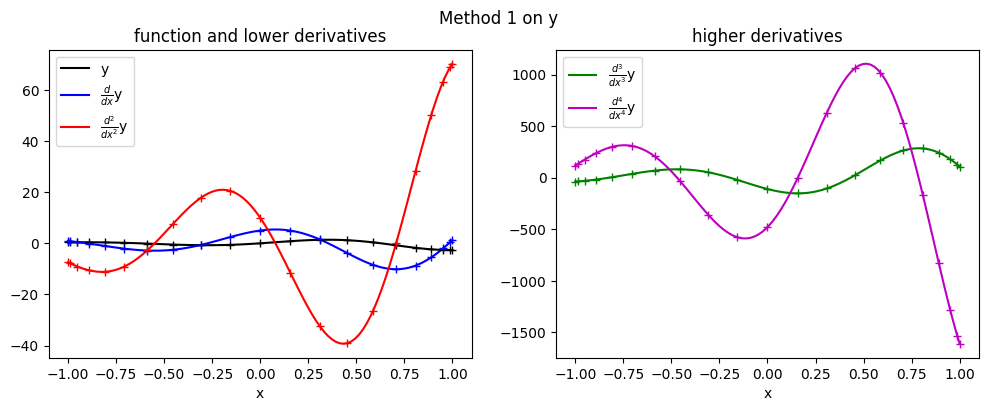

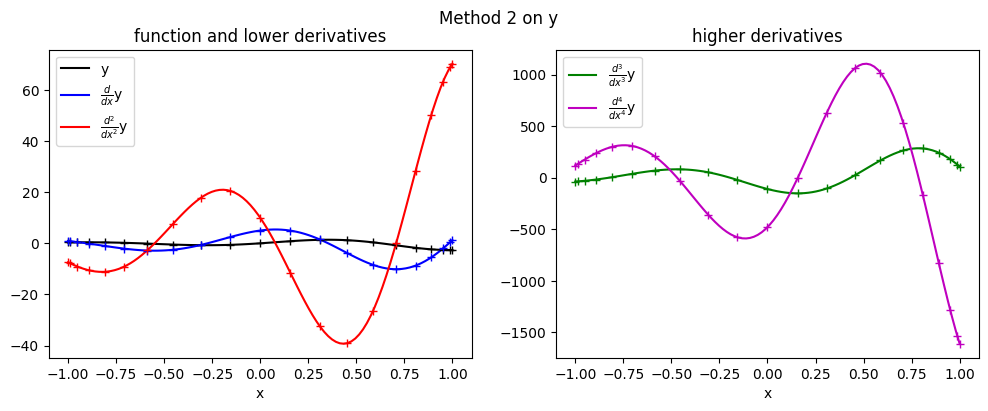

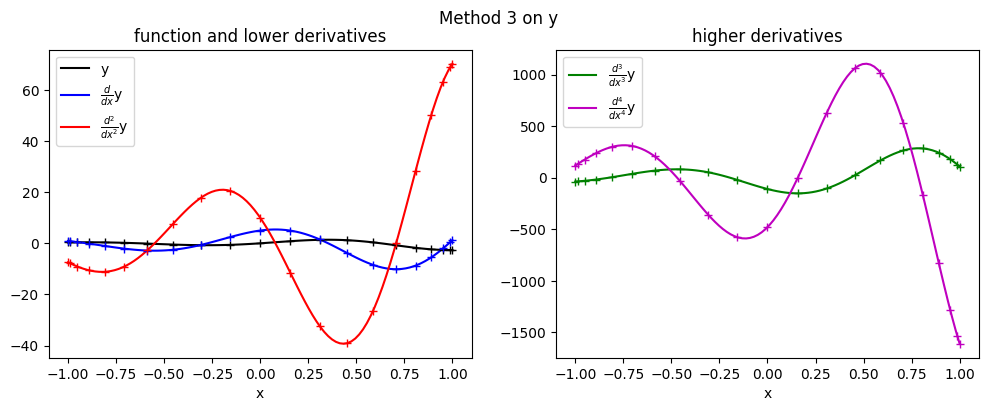

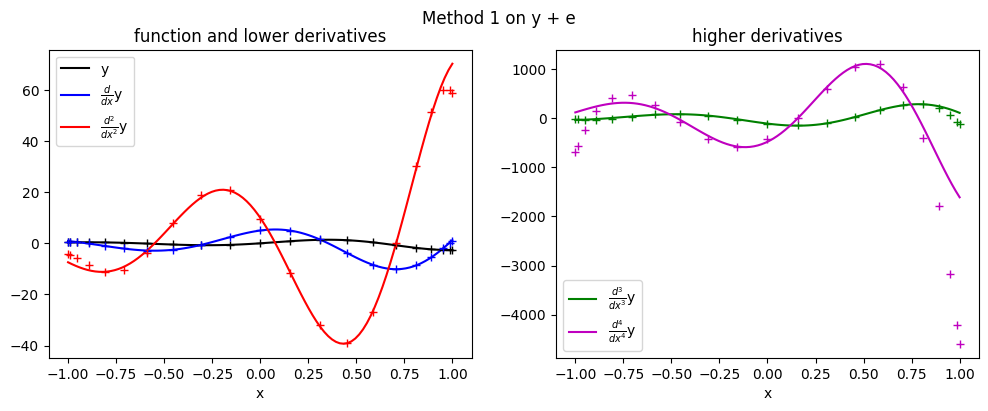

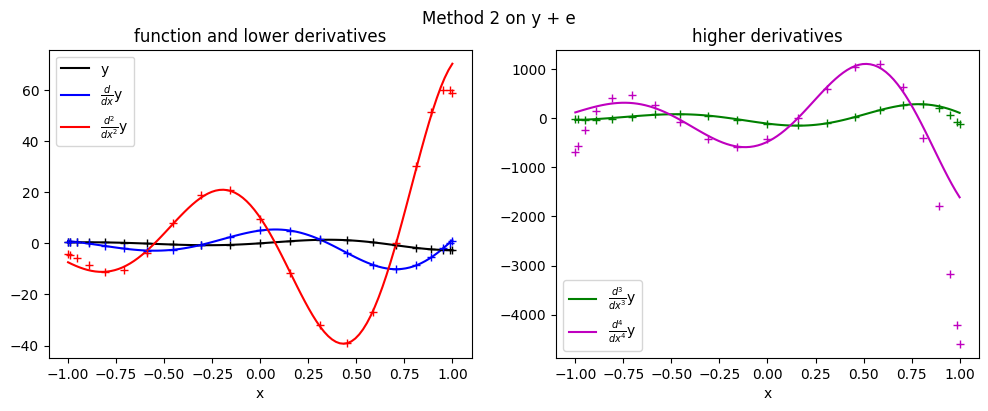

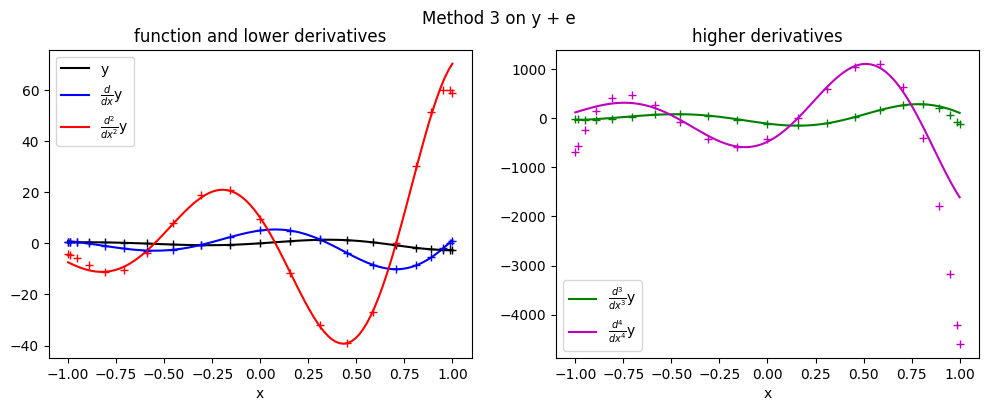

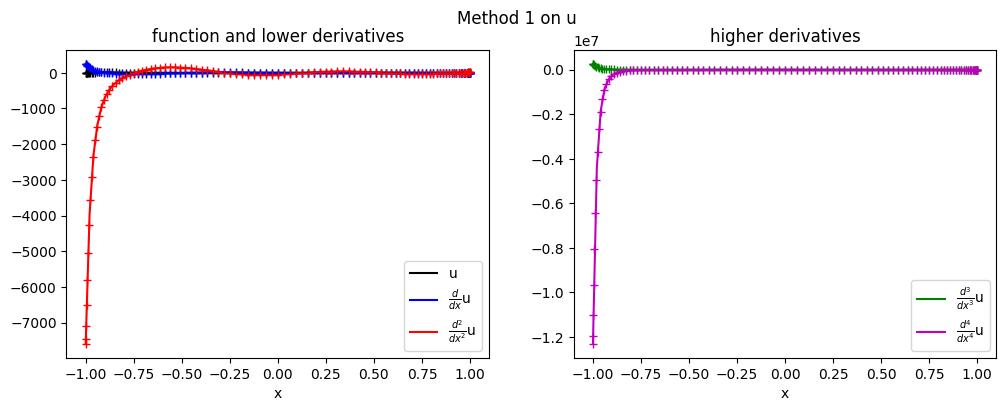

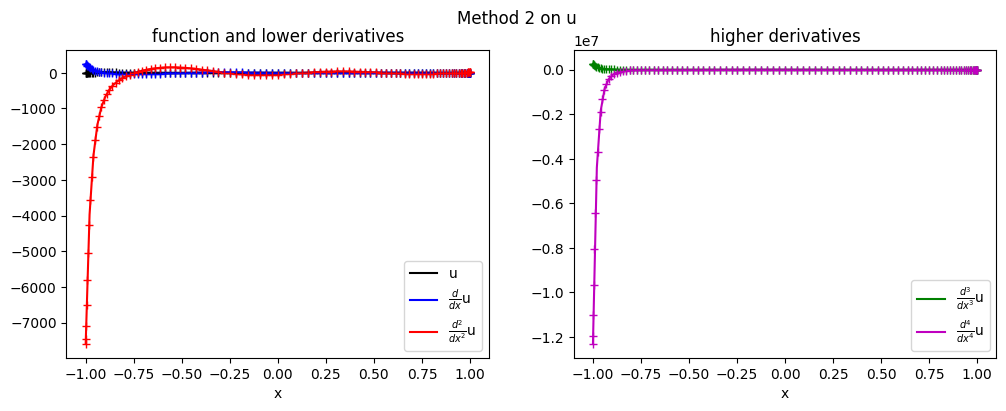

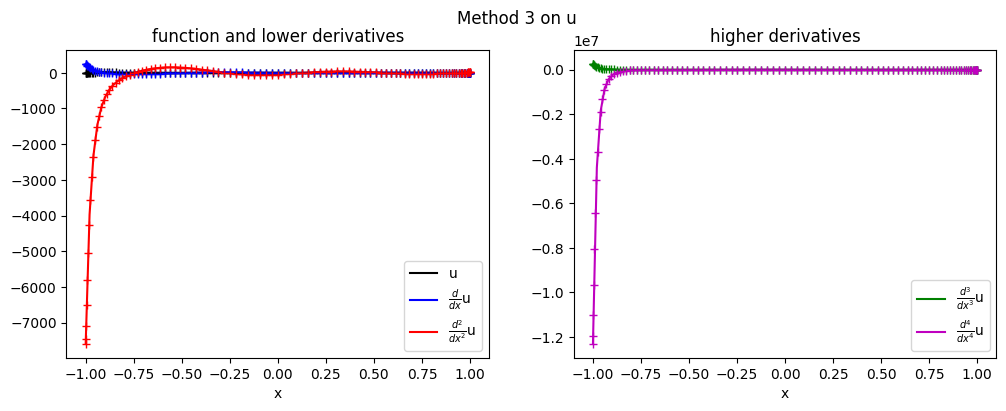

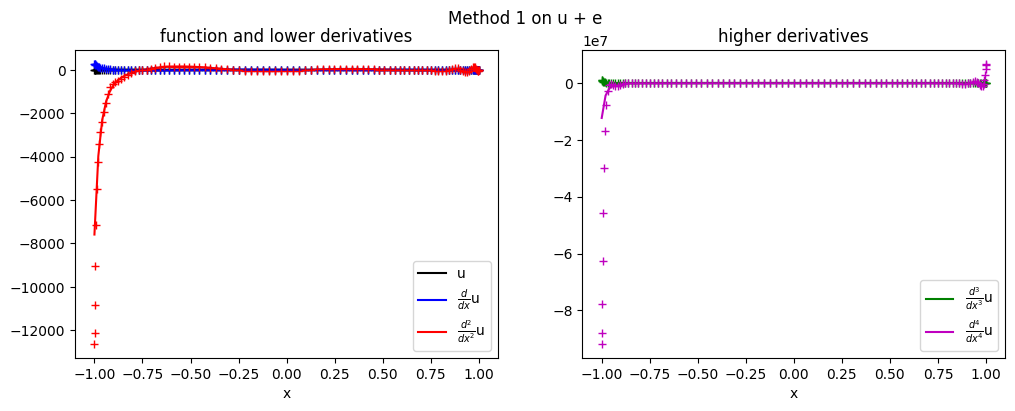

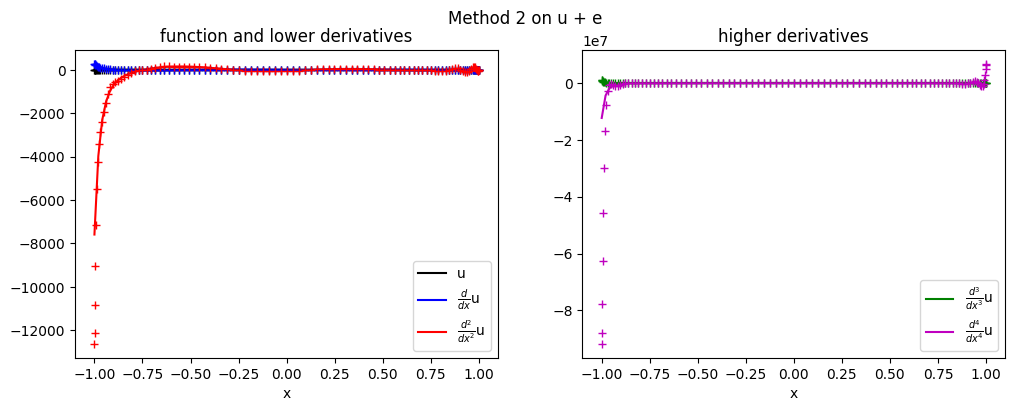

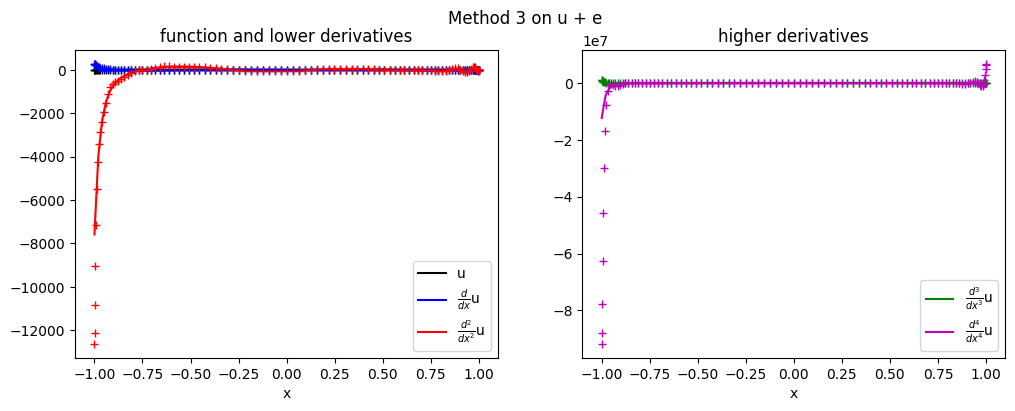

In [6]:
L2_results = pandas.DataFrame(index=['y', 'y + e', 'u', 'u + e'], columns=['Method 1', 'Method 2', 'Method 3'])
Linf_results = pandas.DataFrame(index=['y', 'y + e', 'u', 'u + e'], columns=['Method 1', 'Method 2', 'Method 3'])
runtimes = pandas.DataFrame(index=['y', 'y + e', 'u', 'u + e'], columns=['Method 1', 'Method 2', 'Method 3'])
noises = [np.random.randn(21), np.random.randn(101)]

# Iterate the two test functions
for row,N,f,noise in [('y',20,[y,dy,d2y,d3y,d4y],noises[0]), ('u',100,[u,du,d2u,d3u,d4u],noises[1])]:
	x_n = np.cos(np.arange(N+1) * np.pi / N)
	# Iterate without noise and with noise, where we use a filter for some appropriate number of modes in the presence of noise
	for e,noise_level,filter in [('', 0, None), (' + e', 0.05, lambda k: k < (10 if row=='y' else 30))]:
		# Iterate the three methods
		for col,method in [('Method 1',cheb_deriv_via_fourier), ('Method 2',cheb_deriv), ('Method 3',brown_deriv)]:
			# Calculate numerical values, timing the four method runs
			y_n = f[0](x_n) + noise_level*noise
			start = time()
			dy_n = method(y_n, x_n, 1, filter=filter)
			d2y_n = method(y_n, x_n, 2, filter=filter)
			d3y_n = method(y_n, x_n, 3, filter=filter)
			d4y_n = method(y_n, x_n, 4, filter=filter)
			end = time()
			c = [y_n, dy_n, d2y_n, d3y_n, d4y_n] # computed
			# Calculate and save accuracy and runtime metrics
			L2_results.loc[row+e, col] = '<br/>'.join([f"{nu}: {np.linalg.norm(f[nu](x_n)-c[nu])}" for nu in range(len(f))])
			Linf_results.loc[row+e, col] = '<br/>'.join([f"{nu}: {np.max(np.abs(f[nu](x_n)-c[nu]))}" for nu in range(len(f))])
			runtimes.loc[row+e, col] = (end-start)*1000
			# Plot the true function and the numerical derivative output
			fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
			fig.suptitle(col+" on "+row+e)
			axes[0].plot(x, f[0](x), 'k', label=row)
			axes[0].plot(x, f[1](x), 'b', label=r"$\frac{d}{dx}$"+row)
			axes[0].plot(x, f[2](x), 'r', label=r"$\frac{d^2}{dx^2}$"+row)
			axes[0].plot(x_n, y_n, 'k+')
			axes[0].plot(x_n, dy_n, 'b+')
			axes[0].plot(x_n, d2y_n, 'r+')
			axes[0].set_title("function and lower derivatives")
			axes[0].set_xlabel('x')
			axes[0].legend()
			axes[1].plot(x, f[3](x), 'g', label=r"$\frac{d^3}{dx^3}$"+row)
			axes[1].plot(x, f[4](x), 'm', label=r"$\frac{d^4}{dx^4}$"+row)
			axes[1].plot(x_n, d3y_n, 'g+')
			axes[1].plot(x_n, d4y_n, 'm+')
			axes[1].set_title("higher derivatives")
			axes[1].set_xlabel('x')
			axes[1].legend()

All methods look pretty identical. In fact, they essentially are, only disagreeing after many decimal places:

In [7]:
display(HTML(L2_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(Linf_results.style.set_caption("Linf").set_properties(**{'text-align': 'left'}).to_html(escape=False)))
display(HTML(runtimes.style.set_caption("runtimes in ms").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

,Method 1,Method 2,Method 3
y,0: 0.01: 1.3707269050628182e-092: 2.0180907461774206e-073: 2.5507543469931667e-054: 0.002025155630747901,0: 0.01: 1.3707253214910556e-092: 2.018090534700036e-073: 2.5507536125433065e-054: 0.002025153662563788,0: 0.01: 1.370730117541387e-092: 2.0180973353295143e-073: 2.550760893263463e-054: 0.0020251591103419534
y + e,0: 0.184951694883148421: 0.5582179419961392: 16.4161853670689663: 336.39236002741774: 4687.84703404156,0: 0.184951694883148421: 0.55821794199613822: 16.4161853670690163: 336.39236002742554: 4687.84703404317,0: 0.184951694883148421: 0.55821794199610712: 16.4161853670680783: 336.392360027412744: 4687.847034043043
u,0: 0.01: 4.7392467275128e-112: 1.2083580274591583e-073: 0.000180438684658431344: 0.21355875317639814,0: 0.01: 4.749504427093539e-112: 1.259773609194821e-073: 0.00019792298106004314: 0.22425232812060653,0: 0.01: 1.5949986292586764e-112: 4.6320819607630196e-083: 7.40535712569852e-054: 0.0794740971057171
u + e,0: 0.52259811269165171: 38.3826732889623942: 8361.2737422864253: 1260968.10766100984: 146865220.1008879,0: 0.52259811269165171: 38.38267328895442: 8361.2737422773793: 1260968.10763504364: 146865219.97600374,0: 0.52259811269165171: 38.382673288992972: 8361.2737422882223: 1260968.10763736564: 146865219.97636044


,Method 1,Method 2,Method 3
y,0: 0.01: 6.717568723502154e-102: 1.7961988874048984e-073: 2.159699207027188e-054: 0.0016393239241097035,0: 0.01: 6.717559841717957e-102: 1.7961987452963513e-073: 2.159699209869359e-054: 0.0016393239236549562,0: 0.01: 6.717981726467315e-102: 1.7962422305117798e-073: 2.1597334935563595e-054: 0.0016393438118029735
y + e,0: 0.105362883964098991: 0.271494523297733052: 11.647557043750193: 235.6981495084894: 2981.8093587964345,0: 0.105362883964098991: 0.27149452329773152: 11.6475570437501833: 235.698149508488944: 2981.8093587964336,0: 0.105362883964098991: 0.27149452329771022: 11.6475570437492883: 235.698149508481044: 2981.809358796381
u,0: 0.01: 4.561684363579843e-112: 1.1525207810336724e-073: 0.000172254221979528674: 0.18731677904725075,0: 0.01: 4.561684363579843e-112: 1.1525116860866547e-073: 0.000172254221979528674: 0.1873167809098959,0: 0.01: 1.4154011296341196e-112: 4.228513716952875e-083: 6.33444869890809e-054: 0.06361768208444118
u + e,0: 0.12302394471129841: 24.221717417252112: 5028.5471743467193: 718470.67520250244: 79403693.20630336,0: 0.12302394471129841: 24.221717417252112: 5028.5471743467223: 718470.67520250254: 79403693.20630337,0: 0.12302394471129841: 24.221717417314752: 5028.5471743553233: 718470.67520404784: 79403693.20652378


,Method 1,Method 2,Method 3
y,6.194115,0.896931,1.683950
y + e,3.381014,0.875950,2.147198
u,3.246069,1.276255,2.206087
u + e,2.982855,1.163721,2.556086


Accuracy-wise there is no clear winner, although Method 3 does pull ahead a tiny bit in cases when N is large, which is what the Brown paper was trying to address. But these differences are so tiny they're overwhelmed by noise of any kind, which means there is essentially no difference, and we can use whichever method we like with equal success.

Runtime-wise Method 2 is clearly superior, although Method 3 may be unfairly suffering a slowdown due to the way I've implemented higher derivatives with a recursive tail call.

The simplicity of Method 2 breaks the tie for me, which is why it has ended up in the library code.

### Epilogue: Filtering $g$ Instead of $y$ in Method 3 

Now that we have the performances and plots above, it's worth a quick comparison to Method 3 when we filter its constructed $g$ rather than the input directly. I'm using the same noise as above for consistency.

,Method 3 L2,Method 3 Linf
y,0: 3.6990338976629681: 16.0608054462350442: 348.273982221753443: 4459.6040531186424: 37787.87257768533,0: 2.10725767928197841: 11.1932533127481092: 241.690710533205623: 2842.33608719870244: 22012.802319129787
u,0: 10.4519622538330331: 771.00401341743432: 168575.16203440683: 25530434.055475184: 2988768120.871536,0: 2.4604788942259661: 487.013522181451552: 101469.160128094593: 14562449.6665254744: 1618800239.0051515


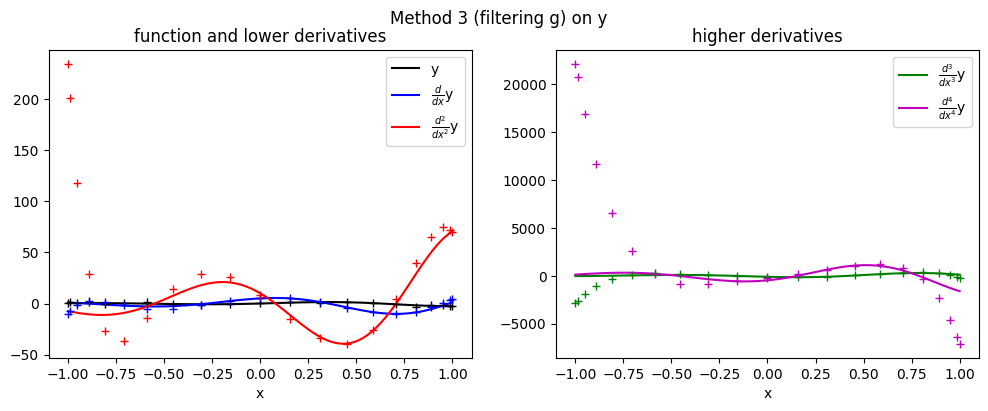

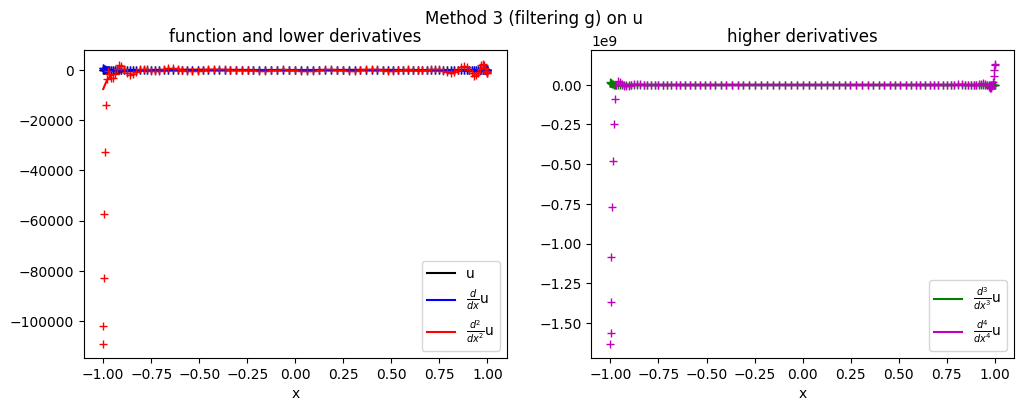

In [ ]:
L_results = pandas.DataFrame(index=['y', 'u'], columns=['Method 3 L2', 'Method 3 Linf'])

# Iterate the two test functions
for row,N,f,noise in [('y',20,[y,dy,d2y,d3y,d4y],noises[0]), ('u',100,[u,du,d2u,d3u,d4u],noises[1])]:
	x_n = np.cos(np.arange(N+1) * np.pi / N)
	filter = lambda k: k < (10 if row=='y' else 30)
	
	# Calculate numerical values, timing the four method runs
	y_n = f[0](x_n) + noise # use the same noise as last time
	dy_n = brown_deriv(y_n, x_n, 1, filter=filter, filter_input=False, filter_g=True)
	d2y_n = brown_deriv(y_n, x_n, 2, filter=filter, filter_input=False, filter_g=True)
	d3y_n = brown_deriv(y_n, x_n, 3, filter=filter, filter_input=False, filter_g=True)
	d4y_n = brown_deriv(y_n, x_n, 4, filter=filter, filter_input=False, filter_g=True)
	c = [y_n, dy_n, d2y_n, d3y_n, d4y_n] # computed
	# Save metrics
	L_results.loc[row, col+' L2'] = '<br/>'.join([f"{nu}: {np.linalg.norm(f[nu](x_n)-c[nu])}" for nu in range(len(f))])
	L_results.loc[row, col+' Linf'] = '<br/>'.join([f"{nu}: {np.max(np.abs(f[nu](x_n)-c[nu]))}" for nu in range(len(f))])
	# Plot the true function and the numerical derivative output
	fig, axes = pyplot.subplots(1, 2, figsize=(12,4))
	fig.suptitle(col+" (filtering g) on "+row)
	axes[0].plot(x, f[0](x), 'k', label=row)
	axes[0].plot(x, f[1](x), 'b', label=r"$\frac{d}{dx}$"+row)
	axes[0].plot(x, f[2](x), 'r', label=r"$\frac{d^2}{dx^2}$"+row)
	axes[0].plot(x_n, y_n, 'k+')
	axes[0].plot(x_n, dy_n, 'b+')
	axes[0].plot(x_n, d2y_n, 'r+')
	axes[0].set_title("function and lower derivatives")
	axes[0].set_xlabel('x')
	axes[0].legend()
	axes[1].plot(x, f[3](x), 'g', label=r"$\frac{d^3}{dx^3}$"+row)
	axes[1].plot(x, f[4](x), 'm', label=r"$\frac{d^4}{dx^4}$"+row)
	axes[1].plot(x_n, d3y_n, 'g+')
	axes[1].plot(x_n, d4y_n, 'm+')
	axes[1].set_title("higher derivatives")
	axes[1].set_xlabel('x')
	axes[1].legend()

display(HTML(L_results.style.set_caption("L2").set_properties(**{'text-align': 'left'}).to_html(escape=False)))

The wiggles and wobbles are overwhelming, because the initial division by $sqrt{1-x^2}$ blows up noise from $y$ in $g$, and then attempting to fit those peaky edges, even with fewer modes, becomes problematic. This is clearly not the way to go.